<a href="https://colab.research.google.com/github/lvu5/lung/blob/Huyen/retina_resnet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-family:verdana;"> <center> RetinaNet 🎖</center> </h1>

<h3><center style="color:#159364; font-family:cursive;">💬 KICK-START this competition with RetinaNet</center></h3>

<img src="https://lh3.googleusercontent.com/1TaNTTbCmw4E94xU7XKdTQ-CR6t7lnqA_YLgXosi2S3_1eDzehkcjv3qnzkxjKmUOzxKzxqHg45vql5G8wChVh4B6W91GjQTTnV3PZybyMAZSch2n6ckY0P9sqKUbrxOwrCnSq-J">

<br>

📌  Special Thanks to
* https://github.com/fizyr/keras-retinanet
* https://www.kaggle.com/awsaf49 for the (.png) Dataset

<hr>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Project_DL/'

In [ ]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import StratifiedKFold
import warnings

<h2 style="font-family:verdana;"> <center>📂 Config File</center> </h2>

<hr>

In [ ]:
class Cfg(object):
  
  def __init__(self):
    super(Cfg, self).__init__()
    self.dim = 512
    self.batch= 8
    self.steps= 500
    self.epochs= 10
    self.train_csv= '/content/drive/MyDrive/Project_DL/vinbigdata/train.csv'.format(self.dim)
    self.test_csv= '/content/drive/MyDrive/Project_DL/vinbigdata/test.csv'.format(self.dim)
    self.img_dir= '/content/drive/MyDrive/Project_DL/vinbigdata/train/'.format(self.dim)
    
    self.git= 'https://github.com/fizyr/keras-retinanet.git'
    self.model_url= ['https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5',
               'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet101_oid_v1.0.0.h5',
               'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet152_oid_v1.0.0.h5']
    
    self.color_code=   {'Cardiomegaly':(124,252,0), 'Aortic enlargement':(135,206,250),
                        'Pleural thickening':(199,21,133),'ILD':(245,245,220), 'Nodule/Mass':(220,20,60),
                        'Pulmonary fibrosis':(0,255,255), 'Lung Opacity':(128,128,0), 'Atelectasis':(255,0,255),
                        'Other lesion':(176,224,230), 'Infiltration':(210,105,30),'Pleural effusion':(105,105,105),
                        'Calcification':(138,43,226) ,'Consolidation':(250,240,230),'Pneumothorax':(100,149,237)}
    
cfg= Cfg()

<h2 style="font-family:verdana;"> <center>📚 Data Processing for Retinanet</center> </h2>




<hr>

In [ ]:
df= pd.read_csv(cfg.train_csv)
print(df.shape)
df= df[df.class_name != 'No finding']
display(df.head())
df.shape

(67914, 10)


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353


(36096, 10)

In [ ]:
def load_img(path):
    img= cv2.imread(path)
    img= cv2.resize(img, (cfg.dim, cfg.dim))
    return img

def normalize_cod(df):
    df.x_min= (df.x_min/ df.width)* cfg.dim
    df.x_max= (df.x_max/ df.width)* cfg.dim
    
    df.y_min= (df.y_min/ df.height)* cfg.dim
    df.y_max= (df.y_max/ df.height)* cfg.dim
    return df

df= normalize_cod(df.copy())
df= df.reset_index(drop = True)

df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,170.092308,301.369863,406.892308,401.315068,2080,2336
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,280.888889,132.088889,358.000000,181.155556,2304,2880
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,126.387402,59.500000,190.891339,72.166667,2540,3072
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,301.822319,49.095890,490.265208,434.648924,2285,2555
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,111.052960,359.148225,134.579439,379.304503,2568,3353


In [ ]:

classes= df.class_name.unique()
ind= df.class_id.unique()

In [ ]:
##### Color-Code ########
color= cfg.color_code

def show_bb(i):
    df_mini= df[df.image_id==df.image_id[i]]
    path= cfg.img_dir + df.image_id[i] + '.png'
    img= load_img(path)
    rep_class=[]
    font = cv2.FONT_HERSHEY_SIMPLEX 
    for i, row in df_mini.iterrows():
        class_n= row['class_name']
        if class_n in rep_class:
            continue                          # More generalization
        rep_class.append(class_n)
        x_min= int(row['x_min']); x_max= int(row['x_max'])
        y_min= int(row['y_min']); y_max= int(row['y_max'])
        img= cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color[class_n], 2)
        fontScale= (x_max- x_min)*2.5/img.shape[1]
        img= cv2.putText(img, class_n, (x_min, y_min-5), font, fontScale, cv2.LINE_AA)
    return img

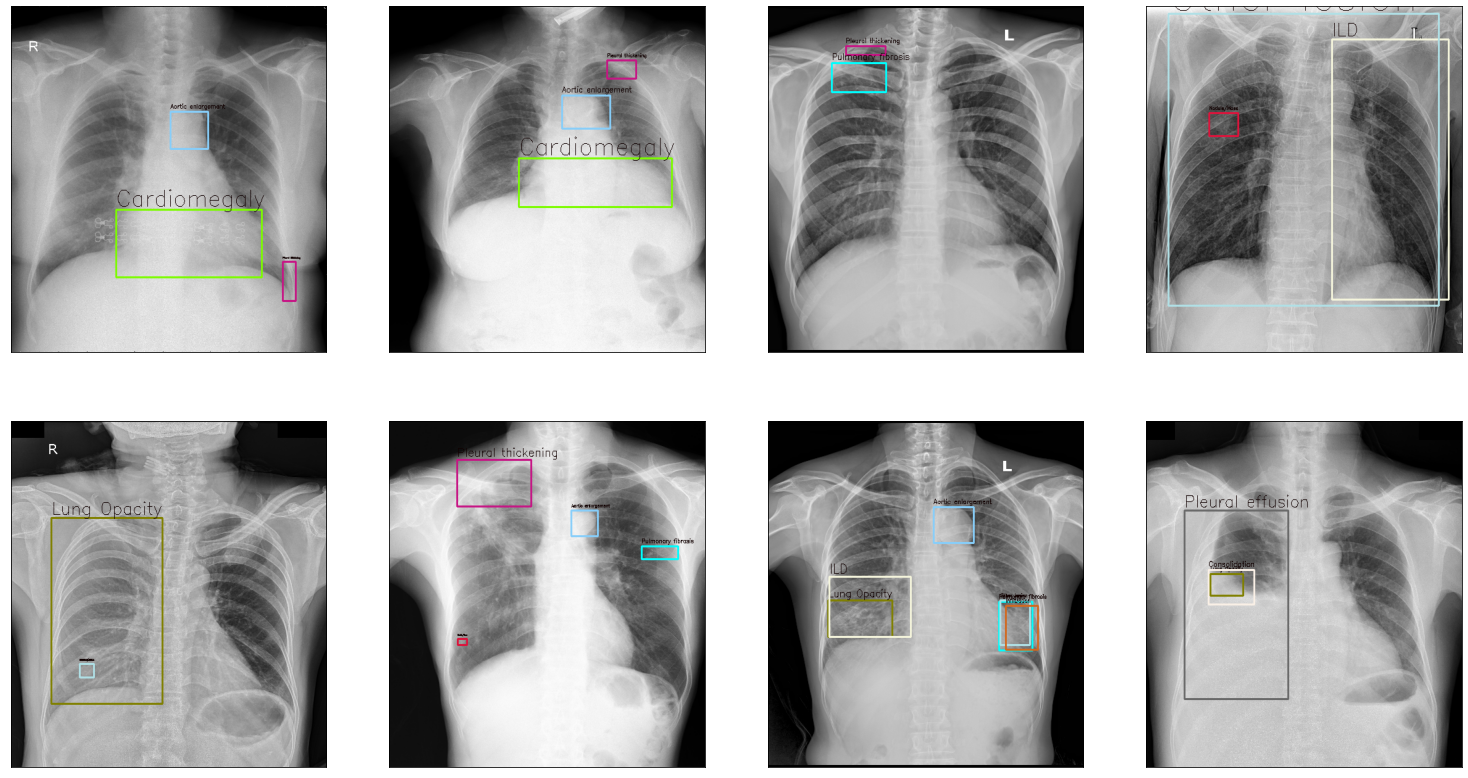

In [ ]:
f, ax= plt.subplots(2, 4, figsize=(26, 14))
for i in range(8):
    ax[i//4][i%4].imshow(show_bb(i), aspect='auto')
    ax[i//4][i%4].set_xticks([]); ax[i//4][i%4].set_yticks([])
plt.show()

<h2 style="font-family:verdana;"> <center>Data Spliting</center> </h2>

<hr>

In [ ]:
'''
https://www.kaggle.com/backtracking/smart-data-split-train-eval-for-object-detection
'''

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
df_folds = df[['image_id']].copy()

df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'object_count'] = df.groupby('image_id')['class_id'].nunique()

df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['object_count'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)

df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
df_folds.reset_index(inplace=True)

df_valid = pd.merge(df, df_folds[df_folds['fold'] == 0], on='image_id')
df_train = pd.merge(df, df_folds[df_folds['fold'] != 0], on='image_id')

df_train.shape, df_valid.shape

((28940, 14), (7156, 14))

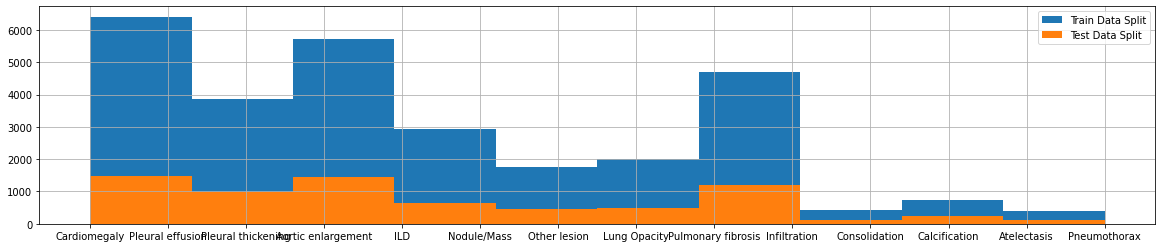

In [ ]:
plt.figure(figsize=(20, 4))
plt.hist(df_train['class_name'], label='Train Data Split')
plt.hist(df_valid['class_name'], label='Test Data Split')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Train set
df_train= df_train[['image_id','x_min', 'y_min', 'x_max', 'y_max', 'class_name']]
df_train.image_id= df_train.image_id.apply(lambda x: cfg.img_dir+ x+ '.png')
df_train.iloc[:,1:-1]=df_train.iloc[:,1:-1].astype('int32')

# validation set
df_valid= df_valid[['image_id','x_min', 'y_min', 'x_max', 'y_max', 'class_name']]
df_valid.image_id= df_valid.image_id.apply(lambda x: cfg.img_dir+ x+ '.png')
df_valid.iloc[:,1:-1]=df_valid.iloc[:,1:-1].astype('int32')



In [ ]:
df_train['image_id'][0]
# just Sanity check stuff

# df_train= df_train.drop(df_train[df_train.y_max== df_train.y_min].index[0])
df_valid= df_valid.drop(df_valid[df_valid.y_max== df_valid.y_min].index[0])


<h2 style="font-family:verdana;"> <center>🏛 DRetinanet architecture</center> </h2>

![00194_psisdg11321_113210f_page_2_1](https://user-images.githubusercontent.com/64481847/103896119-7d1bbe80-5117-11eb-893e-a0efbfa3fc31.jpg)


<hr>

<h2 style="font-family:verdana;"> <center>⚙️ RetinaNet installation</center> </h2>


<hr>


In [ ]:
################## RETINANET #######################
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 14.87 MiB | 34.76 MiB/s, done.
Resolving deltas: 100% (4195/4195), done.


In [ ]:
%%capture

%cd keras-retinanet/
!pip install .

In [ ]:
####### Saving csv and classes files ##########
df_train.to_csv('annotations.csv', index=False, header=None)
df_valid.to_csv('annotations_test.csv', index=False, header = None)


print(classes)

with open("classes.csv","w") as file:
    for i, cn in zip(ind, classes):
        file.write('{},{}\n'.format(cn, i))

['Cardiomegaly' 'Aortic enlargement' 'Pleural thickening' 'ILD'
 'Nodule/Mass' 'Pulmonary fibrosis' 'Lung Opacity' 'Atelectasis'
 'Other lesion' 'Infiltration' 'Pleural effusion' 'Calcification'
 'Consolidation' 'Pneumothorax']


In [ ]:
import tensorflow
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr ,preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import requests
import urllib

In [ ]:
pretrained_model = '/content/drive/MyDrive/Project_DL/model/pretrained_model_101.h5'

# model_url = cfg.model_url[1]
# urllib.request.urlretrieve(model_url, pretrained_model)

# print("Downloaded pretrained model- {} to-'{}'".format(model_url, pretrained_model))

In [ ]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [ ]:
!keras_retinanet/bin/train.py --backbone resnet101\
  --random-transform \
  --workers 0 \
  --snapshot-path /content/drive/MyDrive/Project_DL/model_101/ \
  --weights {'/content/drive/MyDrive/Project_DL/model/pretrained_model_101.h5'} \
  --batch-size 8 \
  --steps 200 \
  --image-min-side 512\
  --image-max-side 512\
  --lr 1e-5 \
  --epochs 30 \
  --weighted-average \
  csv annotations.csv classes.csv

2021-01-16 07:55:58.571792: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2021-01-16 08:09:01.270580: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-16 08:09:01.272109: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-16 08:09:01.334473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-16 08:09:01.335081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2021-01-16 08:09:01.335117: I tensorflow/

# Load & Test model


In [ ]:
!retinanet-convert-model /content/drive/MyDrive/Project_DL/model_101/resnet101.h5 /content/drive/MyDrive/Project_DL/model_101/resnet101.h5
!retinanet-evaluate csv annotations_test.csv classes.csv /content/drive/MyDrive/Project_DL/model_101/resnet101.h5

2021-01-16 11:51:39.989291: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-01-16 11:51:41.719985: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-16 11:51:41.721264: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-16 11:51:41.786626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-16 11:51:41.787289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2021-01-16 11:51:41.787351: I tensorflow/stream_executor/platform/default/dso_loade

In [ ]:
!retinanet-convert-model /content/drive/MyDrive/Project_DL/model_152/resnet152.h5 /content/drive/MyDrive/Project_DL/model_152/resnet152.h5
!retinanet-evaluate csv annotations_test.csv classes.csv /content/drive/MyDrive/Project_DL/model_152/resnet152.h5

2021-01-16 12:03:18.591489: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-01-16 12:03:20.297490: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-16 12:03:20.298470: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-16 12:03:20.334904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-16 12:03:20.335528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2021-01-16 12:03:20.335570: I tensorflow/stream_executor/platform/default/dso_loade